In [ ]:
import pandas as pd
!pip install pandasql
from pandasql import sqldf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.api as sm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data Cleaning and Wrangling

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv')
df.head()

,Month,Monthly milk production: pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [ ]:
df = df.rename(columns = {'Monthly milk production: pounds per cow': 'Milk_Prod'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      169 non-null    object 
 1   Milk_Prod  168 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
df.isnull().sum()

Month        1
Milk_Prod    2
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.isnull().sum()

Month        0
Milk_Prod    0
dtype: int64

In [ ]:
df.describe()

,Milk_Prod
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [ ]:
Query_string = """ select * from df where Milk_Prod > 500 ORDER BY Milk_Prod DESC"""
sqldf(Query_string, globals())

,Month,Milk_Prod
0,1974-05,969.0
1,1975-05,966.0
2,1972-05,961.0
3,1973-05,957.0
4,1974-06,947.0
...,...,...
163,1962-09,568.0
164,1963-02,566.0
165,1963-11,565.0
166,1962-02,561.0


#Data Decomposition




### 1) Multiple Box Plot

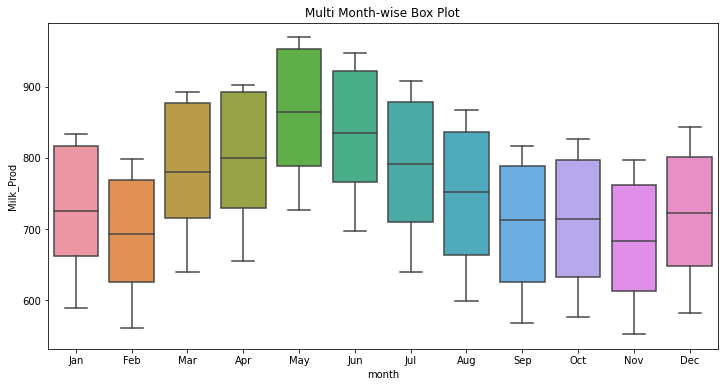

In [ ]:
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
df['month'] = df['Month'].dt.strftime('%b')

df['year'] = [d.year for d in df.Month]

df['month'] = [d.strftime('%b') for d in df.Month]

years = df['year'].unique()
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='Milk_Prod', data=df).set_title("Multi Month-wise Box Plot")
plt.show()

### 2) Seasonality using auto correlation

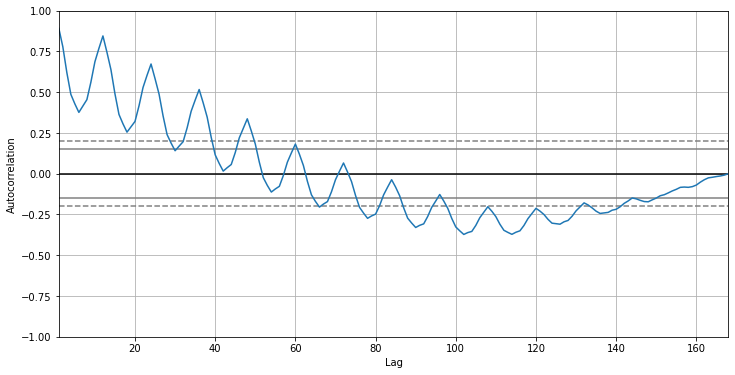

In [ ]:
plt.rcParams.update({'figure.figsize':(12,6)})
autocorrelation_plot(df.Milk_Prod.tolist())

### 3) Deseasoning the time series

#### a) Additive model

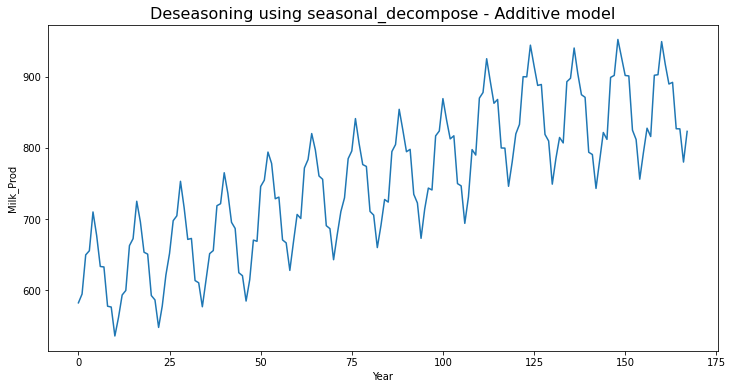

In [ ]:
result_mul = seasonal_decompose(df['Milk_Prod'], model='additive', freq = 6)
deseason = df['Milk_Prod'] - result_mul.seasonal
plt.figure(figsize=(12,6))
plt.plot(deseason)
plt.title('Deseasoning using seasonal_decompose - Additive model', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Milk_Prod')
plt.show()

#### b) Multiplicative model

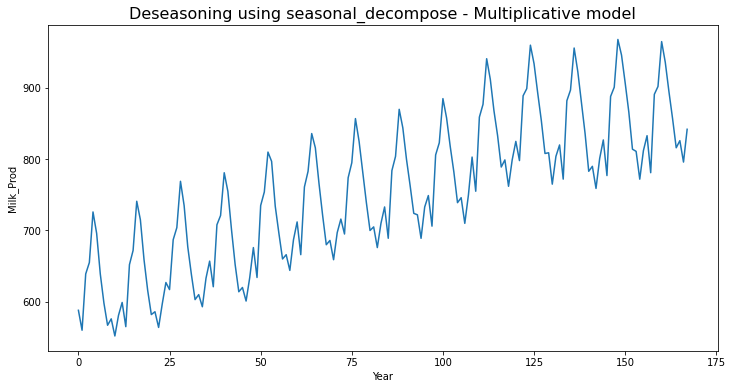

In [ ]:
result_mul = seasonal_decompose(df['Milk_Prod'], model='multiplicative', freq = 6)
deseason = df['Milk_Prod'] - result_mul.seasonal
plt.figure(figsize=(12,6))
plt.plot(deseason)
plt.title('Deseasoning using seasonal_decompose - Multiplicative model', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Milk_Prod')
plt.show()

### 4) Seasonal Decomposition

#### a) From Scratch

In [ ]:
dtemp = df["Milk_Prod"]
dtemp.head()

0    589.0
1    561.0
2    640.0
3    656.0
4    727.0
Name: Milk_Prod, dtype: float64

Text(0.5, 1.0, 'Trend against Time')

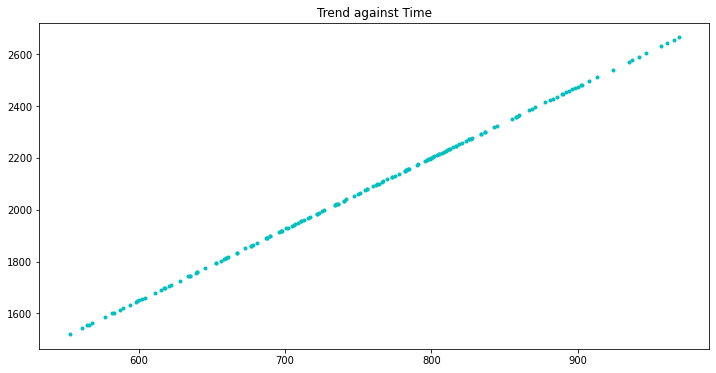

In [ ]:
#create the trend component
T_Series = dtemp
Trend = T_Series * 2.75

#plot the trend
plt.plot(T_Series, Trend, 'c.')
plt.title("Trend against Time")

Text(0.5, 1.0, 'Seasonality against Time')

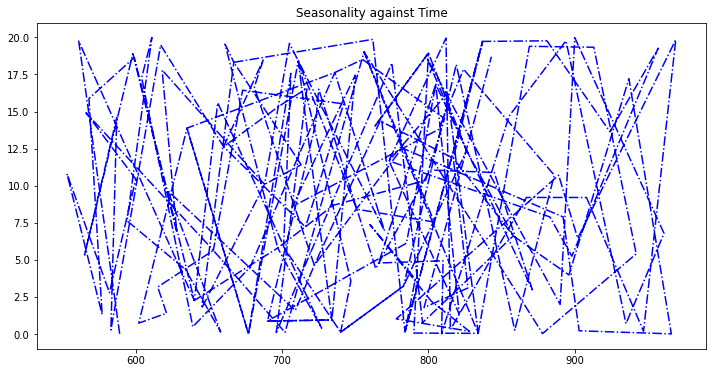

In [ ]:
# creating the seasonality component
seasonality = 10 + np.sin(T_Series) * 10

#plot the seasonality trend
plt.plot(T_Series,  seasonality, 'b-.')
plt.title("Seasonality against Time")

Text(0.5, 1.0, 'Residuals against Time')

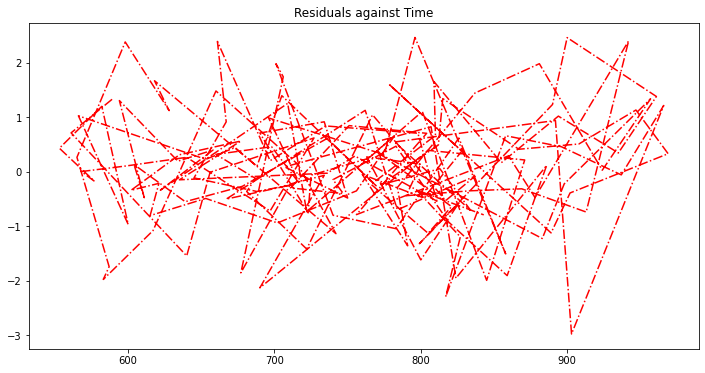

In [ ]:
#creating the residual component
np.random.seed(10)  # for result reproducibility
residual = np.random.normal(loc=0.0, scale=1, size=len(T_Series))

#plot the residual component
plt.plot(T_Series, residual, 'r-.')
plt.title("Residuals against Time")

Text(0.5, 1.0, 'Additive Time Series')

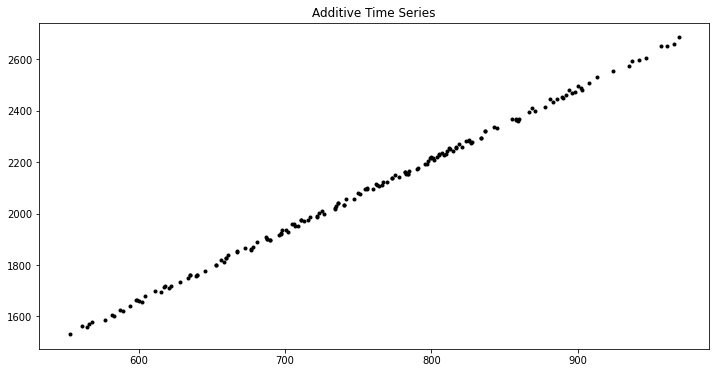

In [ ]:
#create an additive model of our time series
additive_Tmodel = Trend + seasonality + residual

#Plot the additive model
plt.plot(T_Series, additive_Tmodel, 'k.')
plt.title("Additive Time Series")

Text(0.5, 1.0, 'Multiplicative Time Series')

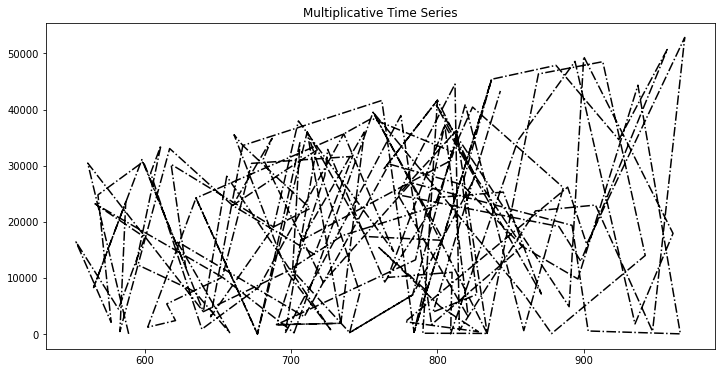

In [ ]:
ignored_residual = np.ones_like(residual)

multiplicative_Tmodel = Trend * seasonality * ignored_residual

plt.plot(T_Series, multiplicative_Tmodel, 'k-.')
plt.title("Multiplicative Time Series")

#### b) Using libraries

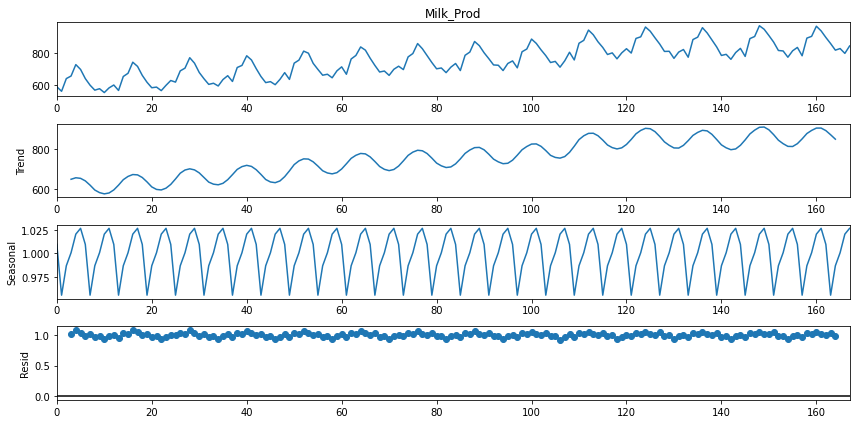

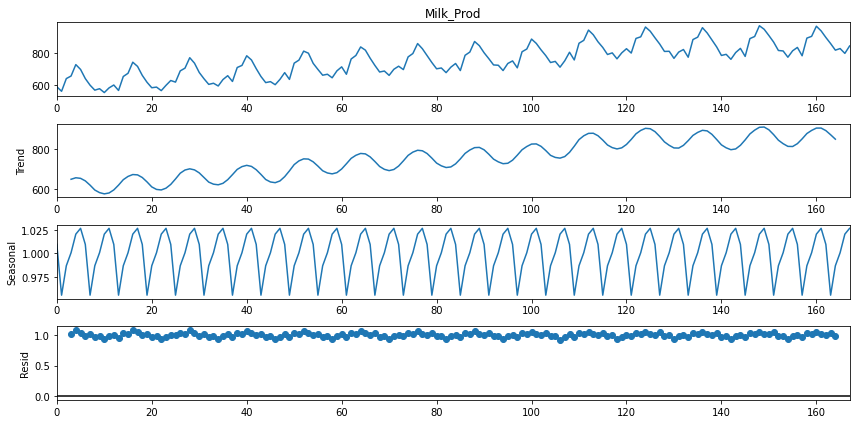

In [ ]:
result = seasonal_decompose(df['Milk_Prod'], model='mul',freq =6)
result.plot()

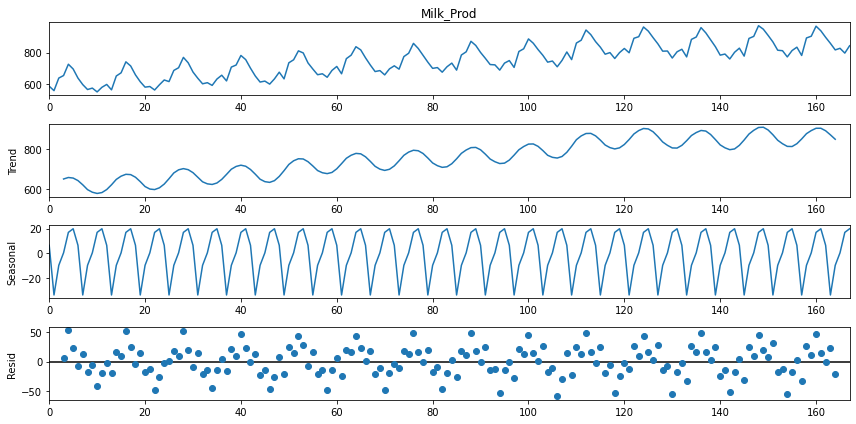

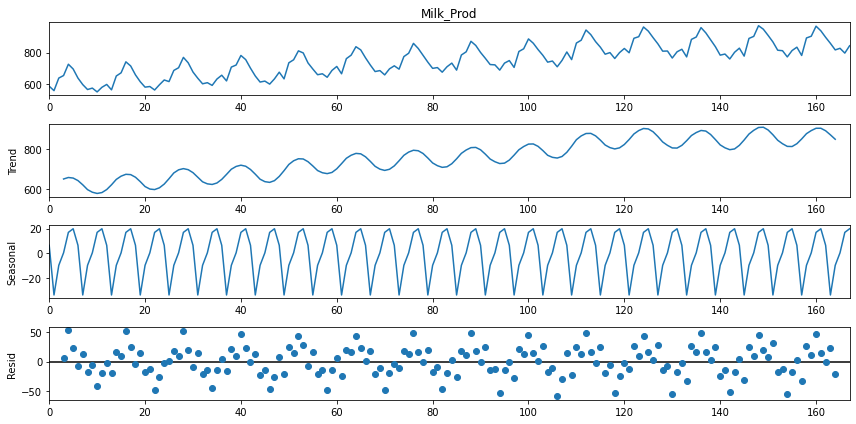

In [ ]:
result = seasonal_decompose(df['Milk_Prod'], model='add', freq =6)
result.plot()

#Smoothing Methods

https://colab.research.google.com/drive/1odoatMSnHKpJQVfAHqMHlJwv6vfdW3pT?usp=sharing


#Testing Stationarity

In [ ]:
milk = pd.read_csv(r'/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv', header=0, index_col=0)
milk.head()

,Monthly milk production: pounds per cow
Month,
1962-01,589.0
1962-02,561.0
1962-03,640.0
1962-04,656.0
1962-05,727.0


In [ ]:
milk.rename(columns = {'Monthly milk production: pounds per cow':'Milk_Production'}, inplace = True)
milk.dropna(inplace = True)

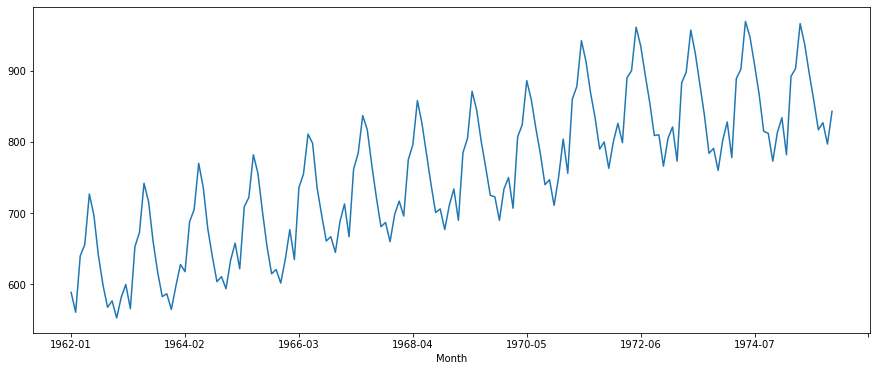

In [ ]:
milk['Milk_Production'].plot(figsize=(15,6))
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='aic') #AIC: Method to use when automatically determining the lag length among the values 0, 1, …, maxlag
    #The t-value measures the size of the difference relative to the variation in your sample data.
    #T is simply the calculated difference represented in units of standard error.
    #The greater the magnitude of T, the greater the evidence against the null hypothesis.

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','No of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value #Critical values for the ADF test for 1%, 5%, and 10% significance levels with the constant model are −3.43, −2.87, and −2.57, respectively.
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")


In [ ]:
Augmented_Dickey_Fuller_Test_func(milk['Milk_Production'],'Milk_Production')

Results of Dickey-Fuller Test for column: Milk_Production
Test Statistic              -1.303812
p-value                      0.627427
No Lags Used                13.000000
No of Observations Used    154.000000
Critical Value (1%)         -3.473543
Critical Value (5%)         -2.880498
Critical Value (10%)        -2.576878
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


a. Calculate the following:

> i.	Test Statistic -1.303812

> ii.	p-value 0.627427

> iii.	No Lags Used 13.000000

> iv.	Number of Observations Used 154.000000

> v.	Critical Value

>
*   1%   : -3.473543
*   5%   : -2.880498
*   10%  : -2.576878

b.	Conclude if the time series data contains unit roots or not.

> The time series data contains unit roots.

c. 	Also, infer if the data is stationary or not.
> Data is not stationary.


d. Apply differencing if the data is not stationary.

> We apply first differencing as follows:





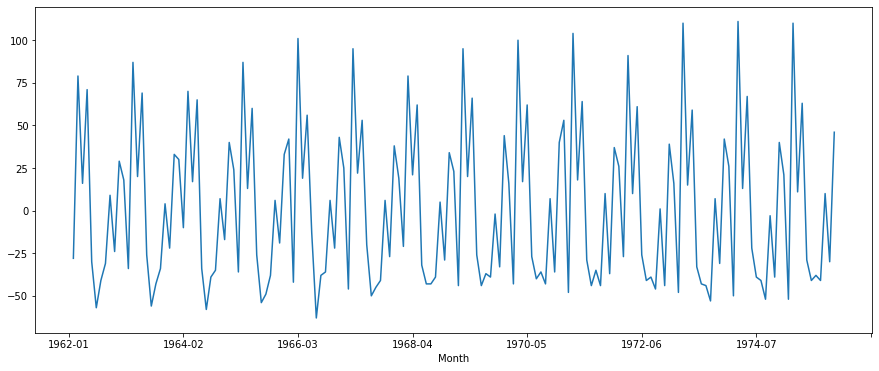

In [ ]:
milk['Milk_Production'].diff().plot(figsize=(15,6))

In [ ]:
milk_firstdiff = milk['Milk_Production'].diff()
Augmented_Dickey_Fuller_Test_func(milk_firstdiff.dropna(),'Milk Production')

Results of Dickey-Fuller Test for column: Milk Production
Test Statistic              -3.054996
p-value                      0.030068
No Lags Used                14.000000
No of Observations Used    152.000000
Critical Value (1%)         -3.474121
Critical Value (5%)         -2.880750
Critical Value (10%)        -2.577013
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


a. Calculate the following:

> i.	Test Statistic -3.054996

> ii.	p-value  0.030068

> iii.	No Lags Used 14.000000

> iv.	Number of Observations Used 152.000000

> v.	Critical Value

>
*   1%   : -3.474121
*   5%   : -2.880750
*   10%  : -2.577013

b.	Conclude if the time series data contains unit roots or not.

> The time series data does not contain unit roots anymore.

c. 	Also, infer if the data is stationary or not.
> Data is now stationary.


d. Apply differencing if the data is not stationary.

> Now the data is stationary.





#Implementation and interpretation for forecast

##Model 1: ARIMA

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv', parse_dates = True)

In [ ]:
df.head(5)

,Month,Monthly milk production: pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [ ]:
df.dropna(inplace=True)
df.rename(columns = {'Monthly milk production: pounds per cow':'Milk_Prod'}, inplace = True)
df.head(5)

,Month,Milk_Prod
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


###a.	Plot a histogram and compare the values with N (0,1).

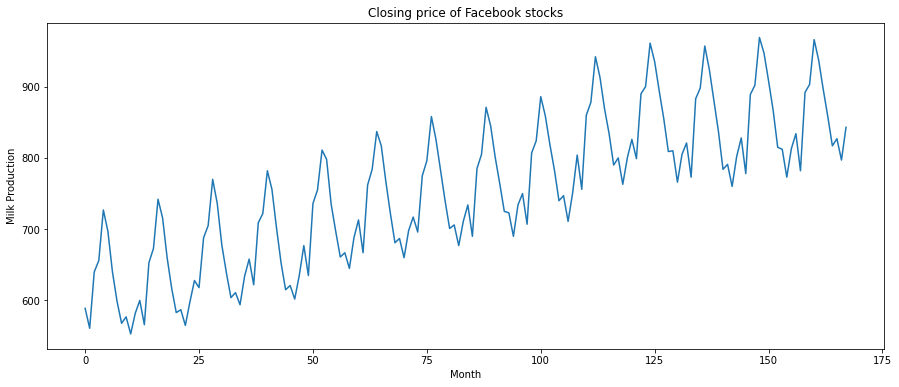

In [ ]:
df["Milk_Prod"].plot(figsize=(15, 6))
plt.xlabel("Month")
plt.ylabel("Milk Production")
plt.title("Closing price of Facebook stocks")
plt.show()

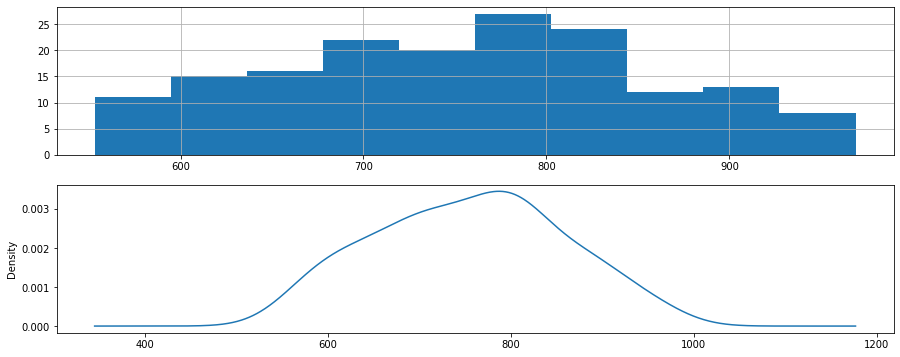

In [ ]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Milk_Prod"].hist()
plt.subplot(212)
df["Milk_Prod"].plot(kind='kde')
plt.show()

###b.	Check for Stationarity.

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df['Milk_Prod' ],'Milk_Prod')

Results of Dickey-Fuller Test for column: Milk_Prod
Test Statistic                  -1.303812
p-value                          0.627427
No Lags Used                    13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Close is non-stationary and auto-arima handles this internally.

###c.	State the coefficients which must be used for the appropriate model selected.

In [ ]:
X = df[['Milk_Prod']]
train, test = X[0:-30], X[-30:]

In [ ]:
stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=7, max_q=7, seasonal=True,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)
print(stepwise_model)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1438.162, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1434.648, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1436.513, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1436.558, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1433.055, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.543 seconds
 ARIMA(0,1,0)(0,0,0)[0]          


In [ ]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  138
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -715.528
Date:                Fri, 02 Dec 2022   AIC                           1433.055
Time:                        14:30:47   BIC                           1435.975
Sample:                             0   HQIC                          1434.242
                                - 138                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2013.8117    292.256      6.891      0.000    1441.000    2586.624
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                11.40
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.60
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto-ARIMA says **ARIMA(0,1,0)** is the optimal selection for the dataset.

Forecast both results and the confidence for the next 30 months and store it in a DataFrame.

**Confidence** is the range of values you expect your estimate to fall between if you redo your test, within a certain level of confidence.

**return_conf_int=True:** Whether to get the confidence intervals of the forecasts.

###d.	Calculate the evaluation metrics (MSE, RMSE, MAPE and R2).

In [ ]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['milk_prod_pred'])

In [ ]:
df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = range(138, 168)
df_conf = df_conf.set_index("new_index")

In [ ]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 8889.466666666667
MAE is : 81.93333333333334
RMSE is : 94.28396823780099
MAPE is : 10.034072890491244
R2 is : -1.5745211058394069



###e.	Forecast the future values and plot Confidence Interval Upper bound and Confidence Interval Lower bound with respect to train, test and predicted.

In [ ]:
forecast["new_index"] = range(138, 168)
forecast = forecast.set_index("new_index")

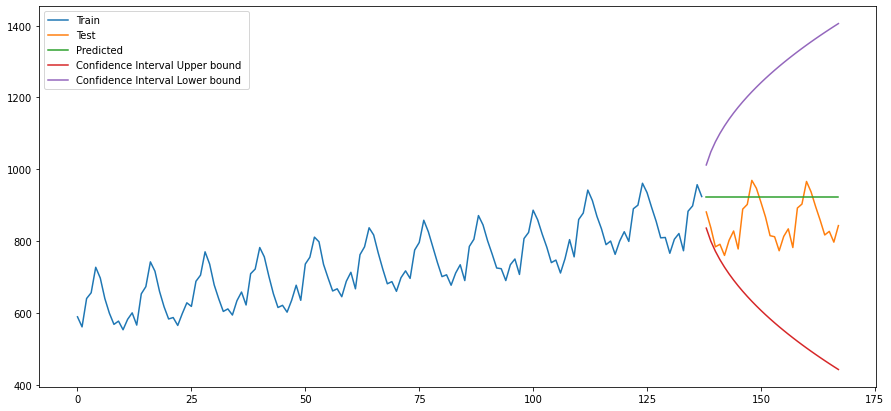

In [ ]:
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

###f.	Analyse the actual data with predicted based on the plots:
i.	Standardize Residual

ii.	Histogram plus estimated density

iii.	Normal Q-Q

iv.	Correlogram


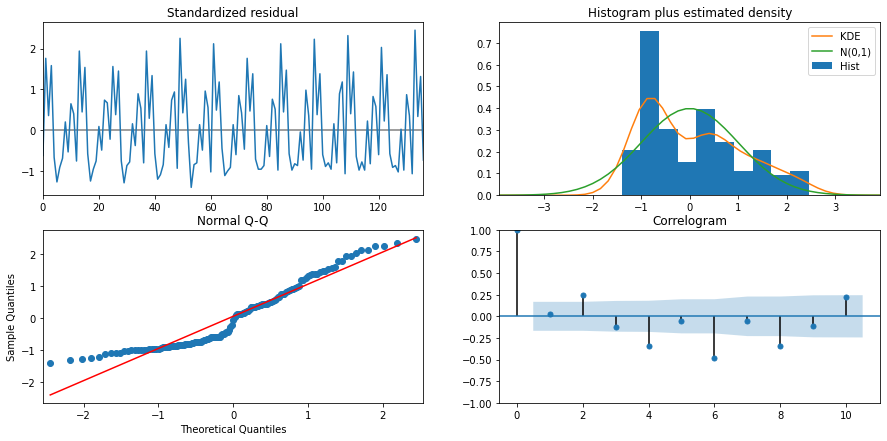

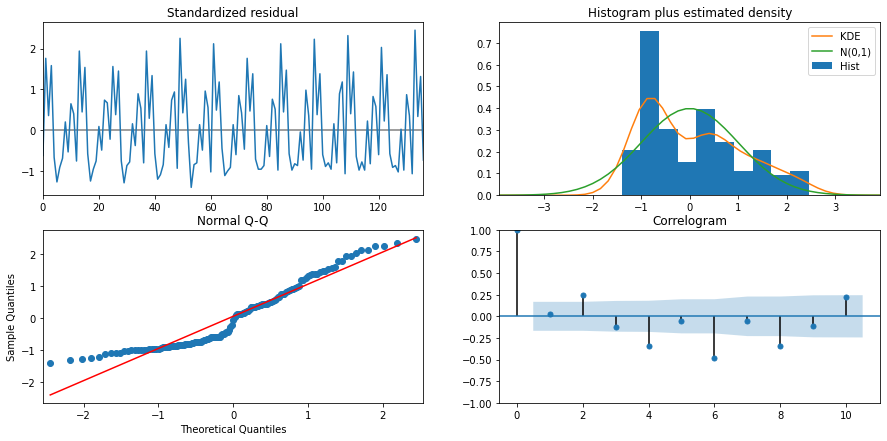

In [ ]:
stepwise_model.plot_diagnostics()

In [ ]:
forecast

,milk_prod_pred
new_index,
138,924.0
139,924.0
140,924.0
141,924.0
142,924.0
143,924.0
144,924.0
145,924.0
146,924.0


##Model 2: CNN

a. Import all the libraries from Keras for neural network architectures.  

In [ ]:
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

b. Define a function that extracts features (lagged values)

In [ ]:
def split_sequence(sequence,steps):
  X,y=[],[]
  for start in range(len(sequence)):
    end_index = start+steps
    if end_index>len(sequence)-1:
      break
    sequence_x,sequence_y = sequence[start:end_index],sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return(array(X),array(y))

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv')
df = df.dropna()
df.head()

,Month,Monthly milk production: pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


c. Initializing Sequence, steps, and reshaping the output to input it to our CNN model.

In [ ]:
raw_sequence = df["Monthly milk production: pounds per cow"]

steps=3
X,y = split_sequence(raw_sequence,steps)

print("The input raw sequence on which we will test our CNN model: ",raw_sequence)
print("The features (X), lagged values of time series, for our CNN model: ",X)
print("The respectice observed values (y)of the sequence for training our CNN model: ",y)


The input raw sequence on which we will test our CNN model:  0      589.0
1      561.0
2      640.0
3      656.0
4      727.0
       ...  
163    858.0
164    817.0
165    827.0
166    797.0
167    843.0
Name: Monthly milk production: pounds per cow, Length: 168, dtype: float64
The features (X), lagged values of time series, for our CNN model:  [[589. 561. 640.]
 [561. 640. 656.]
 [640. 656. 727.]
 [656. 727. 697.]
 [727. 697. 640.]
 [697. 640. 599.]
 [640. 599. 568.]
 [599. 568. 577.]
 [568. 577. 553.]
 [577. 553. 582.]
 [553. 582. 600.]
 [582. 600. 566.]
 [600. 566. 653.]
 [566. 653. 673.]
 [653. 673. 742.]
 [673. 742. 716.]
 [742. 716. 660.]
 [716. 660. 617.]
 [660. 617. 583.]
 [617. 583. 587.]
 [583. 587. 565.]
 [587. 565. 598.]
 [565. 598. 628.]
 [598. 628. 618.]
 [628. 618. 688.]
 [618. 688. 705.]
 [688. 705. 770.]
 [705. 770. 736.]
 [770. 736. 678.]
 [736. 678. 639.]
 [678. 639. 604.]
 [639. 604. 611.]
 [604. 611. 594.]
 [611. 594. 634.]
 [594. 634. 658.]
 [634. 658. 622.]
 [658

d. Reshaping the X matrices

In [ ]:
features = 1
X = X.reshape((X.shape[0],X.shape[1],features))

print("After reshaping, the shape of input X",X.shape)
print("Final form of input feature matrix X",X)
print("Feature matrix X is ready for input to CNN model. We have used feature engineering to convert a sequence to matrix with image matrix shape to find patterns in sequence.")

After reshaping, the shape of input X (165, 3, 1)
Final form of input feature matrix X [[[589.]
  [561.]
  [640.]]

 [[561.]
  [640.]
  [656.]]

 [[640.]
  [656.]
  [727.]]

 [[656.]
  [727.]
  [697.]]

 [[727.]
  [697.]
  [640.]]

 [[697.]
  [640.]
  [599.]]

 [[640.]
  [599.]
  [568.]]

 [[599.]
  [568.]
  [577.]]

 [[568.]
  [577.]
  [553.]]

 [[577.]
  [553.]
  [582.]]

 [[553.]
  [582.]
  [600.]]

 [[582.]
  [600.]
  [566.]]

 [[600.]
  [566.]
  [653.]]

 [[566.]
  [653.]
  [673.]]

 [[653.]
  [673.]
  [742.]]

 [[673.]
  [742.]
  [716.]]

 [[742.]
  [716.]
  [660.]]

 [[716.]
  [660.]
  [617.]]

 [[660.]
  [617.]
  [583.]]

 [[617.]
  [583.]
  [587.]]

 [[583.]
  [587.]
  [565.]]

 [[587.]
  [565.]
  [598.]]

 [[565.]
  [598.]
  [628.]]

 [[598.]
  [628.]
  [618.]]

 [[628.]
  [618.]
  [688.]]

 [[618.]
  [688.]
  [705.]]

 [[688.]
  [705.]
  [770.]]

 [[705.]
  [770.]
  [736.]]

 [[770.]
  [736.]
  [678.]]

 [[736.]
  [678.]
  [639.]]

 [[678.]
  [639.]
  [604.]]

 [[639.]
  [60

e. Define the CNN model.

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64,kernel_size=2,activation="relu",input_shape=(steps,features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

f. Implement CNN Model Fitting.

In [ ]:
model.fit(X,y,epochs=1000,verbose=0)

g. Predict the future values.

In [ ]:
y_pred=[]
for i in range(138,168):
  x_input = array(raw_sequence[i-3:i])
  x_input = x_input.reshape((1,steps,features))
  mp = model.predict(x_input,verbose=0)[0]
  yp = y_pred.append(mp[0])

print(f"The predicted values for the sequence {raw_sequence} for data points between 138 and 167")
print("are",y_pred)

The predicted values for the sequence 0      589.0
1      561.0
2      640.0
3      656.0
4      727.0
       ...  
163    858.0
164    817.0
165    827.0
166    797.0
167    843.0
Name: Monthly milk production: pounds per cow, Length: 168, dtype: float64 for data points between 138 and 167
are [936.11865, 851.8923, 806.4495, 764.918, 759.4829, 751.2463, 782.10986, 804.2042, 798.2645, 905.5056, 933.19794, 949.1377, 952.9298, 879.4255, 833.7303, 794.5124, 779.2638, 765.1379, 791.50665, 809.9722, 801.0512, 907.78906, 934.03955, 944.1784, 946.4997, 866.2094, 821.7299, 787.6525, 789.60724, 786.5853]


h. Plot the graph the predicted value.

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv')
df = df.dropna()
raw_sequence = df["Monthly milk production: pounds per cow"][-30:]
pred= {"Actual Values": raw_sequence, "Predicted values":[936.11865, 851.8923, 806.4495, 764.918, 759.4829, 751.2463, 782.10986, 804.2042, 798.2645, 905.5056, 933.19794, 949.1377, 952.9298, 879.4255, 833.7303, 794.5124, 779.2638, 765.1379, 791.50665, 809.9722, 801.0512, 907.78906, 934.03955, 944.1784, 946.4997, 866.2094, 821.7299, 787.6525, 789.60724, 786.5853]}
df = pd.DataFrame(pred)
df

,Actual Values,Predicted values
138,881.0,936.11865
139,837.0,851.89230
140,784.0,806.44950
141,791.0,764.91800
142,760.0,759.48290
143,802.0,751.24630
144,828.0,782.10986
145,778.0,804.20420
146,889.0,798.26450
147,902.0,905.50560


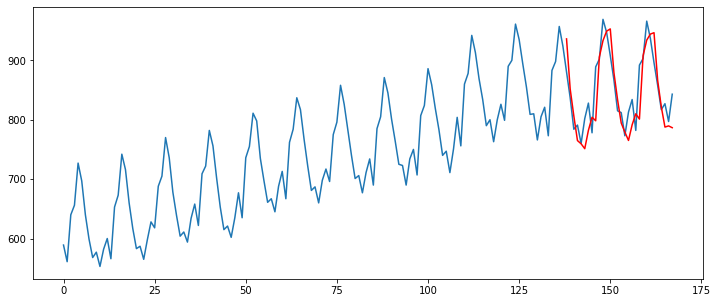

In [ ]:
df["Monthly milk production: pounds per cow"].plot(figsize=(12,5))
plt.plot([i for i in range(138,168)], y_pred, color='r')

In [ ]:
mprod = df['Monthly milk production: pounds per cow']
mprod = list(mprod[138:168])
timeseries_evaluation_metrics_func(y_pred, mprod)

Evaluation metric results:-
MSE is : 1462.8468736467262
MAE is : 29.790791829427082
RMSE is : 38.24718125099844
MAPE is : 3.602589316922293
R2 is : 0.679653367397139



Using CNN:

Evaluation metric results:-


> MSE is : 8889.466666666667

> MAE is : 81.93333333333334

> RMSE is : 94.28396823780099

> MAPE is : 10.034072890491244

> R2 is : -1.5745211058394069


Using CNN:

Evaluation metric results:-

> MSE is : 1462.8468736467262

> MAE is : 29.790791829427082

> RMSE is : 38.24718125099844

> MAPE is : 3.602589316922293

> R2 is : 0.679653367397139


##Model 3: GARCH

In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from random import gauss
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
mp = pd.read_csv('/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv',parse_dates= True)
mp.head()

,Month,Monthly milk production: pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [ ]:
mp.dropna(inplace=True)
mp.rename(columns={"Monthly milk production: pounds per cow": "Monthly_Prod"},inplace=True)
mp.head()

,Month,Monthly_Prod
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [ ]:
returns = 100*mp.Monthly_Prod.pct_change().dropna()

Text(0.5, 1.0, 'Milk Production')

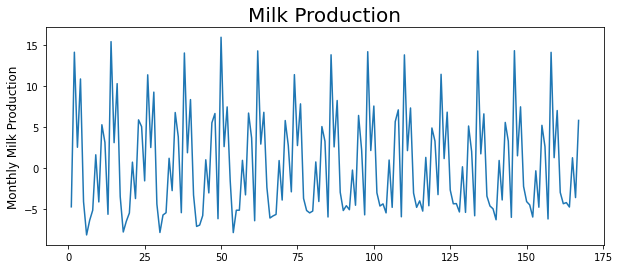

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Monthly Milk Production',fontsize=12)
plt.title('Milk Production',fontsize=20)

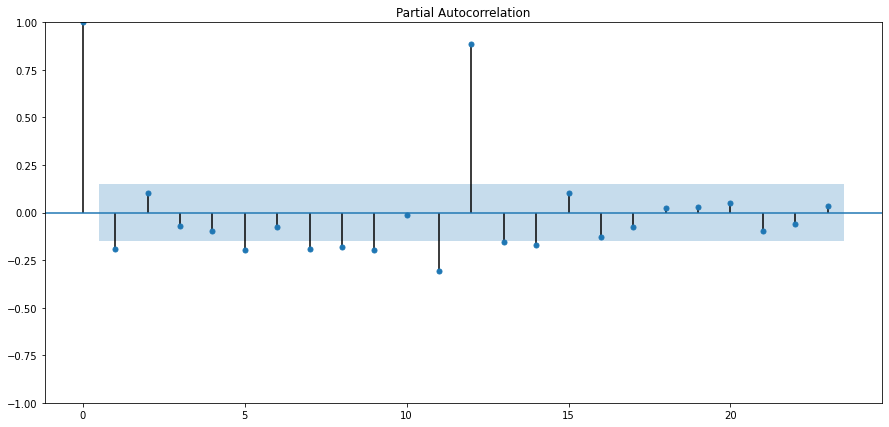

In [ ]:
plot_pacf(returns**2)
plt.show()

Our model does not have any volatilty hence, the above plot shows no PACF value above the threshold. Hence, we can say that GARCH is not a suitable model for out dataset.

In [ ]:
model = arch_model(returns,p=1,q=1)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1202.9208846663814
Iteration:      2,   Func. Count:     14,   Neg. LLF: 540.9095886668101
Iteration:      3,   Func. Count:     19,   Neg. LLF: 540.8783201528573
Iteration:      4,   Func. Count:     24,   Neg. LLF: 540.8732188976921
Iteration:      5,   Func. Count:     29,   Neg. LLF: 540.8308154548415
Iteration:      6,   Func. Count:     34,   Neg. LLF: 542.2548509531562
Iteration:      7,   Func. Count:     40,   Neg. LLF: 541.2846486735282
Iteration:      8,   Func. Count:     46,   Neg. LLF: 541.0363190706321
Iteration:      9,   Func. Count:     52,   Neg. LLF: 541.2907611979283
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4985.12373328337
Iteration:     11,   Func. Count:     66,   Neg. LLF: 540.7738193714922
Iteration:     12,   Func. Count:     72,   Neg. LLF: 540.5895752325059
Iteration:     13,   Func. Count:     77,   Neg. LLF: 540.8246805998508
Iteration:     14,   Func. Count:     83,   Neg. LLF: 540.635600

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Monthly_Prod   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -540.521
Distribution:                  Normal   AIC:                           1089.04
Method:            Maximum Likelihood   BIC:                           1101.51
                                        No. Observations:                  167
Date:                Fri, Dec 02 2022   Df Residuals:                      166
Time:                        14:31:38   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3836      0.390      0.985      0.325 [ -0.380,  1.147]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.4778      1.050      0.455      0.649      [ -1.581,  2.537]
alpha[1]       0.0000  5.070e-02      0.000      1.000 [-9.937e-02,9.937e-02]
beta[1]        0.9846  5.557e-02     17.717  3.082e-70      [  0.876,  1.094]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
rolling_pred = []
test_size=365
for i in range(test_size):
  train = returns[:-(test_size-i)]
  model = arch_model(train,p=1,q=0)
  model_fit = model.fit(disp='off')
  pred = model_fit.forecast(horizon=1)
  rolling_pred.append(np.sqrt(pred.variance.values[-1,:][0]))

In [ ]:
rolling_pred = pd.Series(rolling_pred,index = returns.index[-365:])

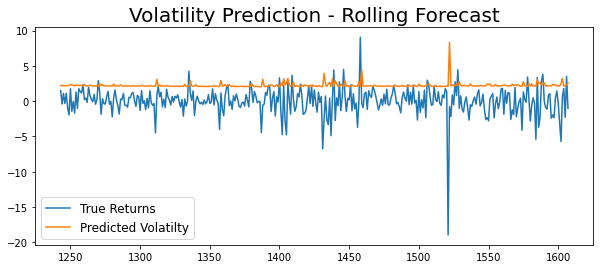

In [ ]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_pred)
plt.title("Volatility Prediction - Rolling Forecast",fontsize = 20)
plt.legend(['True Returns','Predicted Volatilty'],fontsize=12,loc='lower left')